<a href="https://colab.research.google.com/github/chantel808/Springboard_Capstone1/blob/master/Predicting_Vaccine_Interest_in_the_US.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Predicting Vaccine Interest in the U.S.
Dataset is located at: https://www.kaggle.com/GoogleNewsLab/health-searches-us-county 
 * Make sure to downloaded and unzip the data

Vaccinations have saved millions of lives globally by eradicating diseases such as smallpox in the 1970's. There has been increasing interest in vaccinations on Google from 2008 through 2017, and while there has been broader coverage of vaccination across the US, there are still many children who are not vaccinated (https://stacks.cdc.gov/view/cdc/59413).

There may be many reasons for looking up vaccines on Google: preparation for travel abroad, an attempt to gain more information about specific vaccinations for children, pets, research, etc. The list is endless, but there can still be value in finding  how interest in vaccines is changing in the U.S. over time, and how the interest varies by state. 

While Google can provide great resources and general information, it does not always provide credible information and many times will confuse people with conflicting information across various websites. Education about vaccines should be provided by medical professionals.

This analysis has the potential to be turned into a tool with Google's search API which could provide realtime information for medical health providers or organizations that aim to provide professional advice and education about vaccination. Medical providers could determine which US states have the highest interest in vaccination, and therefore help to determine where resources should be allocated for maximum efficacy. If interest is high in certain states, the medical health providers or organizations could begin researching why interest is high or low with surveys for patients and people in various communities. Based on survey results, the health providers could decide which locations need vaccine education the most. 



In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import requests
import zipfile
import io
from collections import Counter
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from plotly.offline import iplot
import plotly.express as px 
import plotly.graph_objects as go
import warnings
from numpy.linalg import LinAlgError
import time

In [2]:
# install watermark extension
!pip install watermark

# once it is installed, you'll just need this in future notebooks:
%load_ext watermark

%watermark -a "Chantel Clark" -d -t -v -p numpy,pandas,matplotlib,seaborn

Chantel Clark 2020-03-27 22:13:06 

CPython 3.6.9
IPython 5.5.0

numpy 1.18.2
pandas 0.25.3
matplotlib 3.2.1
seaborn 0.10.0


This cell with open a window where you can select the data csv file you downloaded.

In [3]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving RegionalInterestByConditionOverTime.csv to RegionalInterestByConditionOverTime.csv
User uploaded file "RegionalInterestByConditionOverTime.csv" with length 85807 bytes


In [4]:
file='RegionalInterestByConditionOverTime.csv'
healthSearchData=pd.read_csv(file)
healthSearchData.head()

,dma,geoCode,2004+cancer,2004+cardiovascular,2004+stroke,2004+depression,2004+rehab,2004+vaccine,2004+diarrhea,2004+obesity,2004+diabetes,2005+cancer,2005+cardiovascular,2005+stroke,2005+depression,2005+rehab,2005+vaccine,2005+diarrhea,2005+obesity,2005+diabetes,2006+cancer,2006+cardiovascular,2006+stroke,2006+depression,2006+rehab,2006+vaccine,2006+diarrhea,2006+obesity,2006+diabetes,2007+cancer,2007+cardiovascular,2007+stroke,2007+depression,2007+rehab,2007+vaccine,2007+diarrhea,2007+obesity,2007+diabetes,2008+cancer,2008+cardiovascular,...,2013+vaccine,2013+diarrhea,2013+obesity,2013+diabetes,2014+cancer,2014+cardiovascular,2014+stroke,2014+depression,2014+rehab,2014+vaccine,2014+diarrhea,2014+obesity,2014+diabetes,2015+cancer,2015+cardiovascular,2015+stroke,2015+depression,2015+rehab,2015+vaccine,2015+diarrhea,2015+obesity,2015+diabetes,2016+cancer,2016+cardiovascular,2016+stroke,2016+depression,2016+rehab,2016+vaccine,2016+diarrhea,2016+obesity,2016+diabetes,2017+cancer,2017+cardiovascular,2017+stroke,2017+depression,2017+rehab,2017+vaccine,2017+diarrhea,2017+obesity,2017+diabetes
0,Portland-Auburn ME,500,44,6,17,39,21,31,14,29,38,70,16,38,11,27,36,26,14,23,55,23,26,25,38,48,48,19,44,70,31,56,38,37,42,22,24,56,68,22,...,70,64,52,66,79,44,70,72,70,72,61,51,75,67,43,61,70,67,64,68,48,73,69,38,70,64,60,64,69,49,81,70,37,83,64,56,76,66,47,80
1,New York NY,501,47,6,13,38,16,33,12,27,32,63,15,35,10,22,29,23,15,19,49,18,18,20,26,38,37,22,33,64,29,43,34,36,41,18,26,48,64,18,...,60,58,44,58,71,33,45,53,58,57,56,39,62,64,36,44,55,53,58,56,46,63,68,41,47,53,51,64,57,49,77,70,34,53,56,53,79,56,52,78
2,Binghamton NY,502,48,3,16,50,12,37,24,31,37,62,8,44,13,25,21,23,24,18,54,19,26,27,20,35,34,30,26,61,20,56,43,28,45,25,43,54,65,15,...,66,65,52,70,80,36,63,74,50,66,75,65,72,64,31,59,69,46,73,84,67,75,74,33,66,66,44,72,79,70,74,68,24,71,69,44,77,78,61,72
3,Macon GA,503,44,14,14,37,19,49,14,29,31,55,25,48,10,29,33,22,23,22,44,24,23,18,39,50,46,29,39,65,42,54,35,40,42,16,36,48,66,23,...,60,62,62,64,72,56,69,60,71,53,68,54,78,66,60,62,68,66,53,71,60,73,63,59,65,56,69,56,66,51,78,53,38,62,46,60,47,53,41,66
4,Philadelphia PA,504,52,7,16,41,23,36,14,30,37,73,17,39,12,32,33,24,18,23,57,24,23,23,40,42,44,24,40,72,34,49,38,46,47,21,31,55,75,23,...,69,68,51,68,81,39,57,62,83,68,66,44,70,71,45,51,63,77,69,67,56,72,74,42,56,59,72,70,70,52,80,75,35,61,62,75,84,69,56,78


In [0]:
# Check for null values
for col in healthSearchData.columns:
  bool_series = pd.isnull(healthSearchData[col])
  if len(healthSearchData[bool_series].index.values) != 0:
    print(healthSearchData[bool_series].index.values)

In [0]:
# Create a 'state_abbrev' column by extracting state, then map state to U.S. region
temp= [] # initialize empty list

for i in healthSearchData['dma']:
  temp.append(i[-2:]) # add last two letters of dma to temp list

healthSearchData['state_abbrev'] = temp # create new column 'state_abbrev'


In [7]:
# Fix index 11 state_abbrev, dma formatting different from other dma's
healthSearchData.set_value(11, 'state_abbrev', 'DC')
healthSearchData.iloc[11]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning:

set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead



dma                    Washington DC (Hagerstown MD)
geoCode                                          511
2004+cancer                                       47
2004+cardiovascular                                5
2004+stroke                                       15
                                   ...              
2017+vaccine                                      79
2017+diarrhea                                     55
2017+obesity                                      59
2017+diabetes                                     73
state_abbrev                                      DC
Name: 11, Length: 129, dtype: object

In [0]:
# Dictionary of state abbreviations to region ('West', 'Midwest', 'Northeast', 'South', and 'O' = other)

states_region = {
        'AK': 'West',
        'AL': 'South',
        'AR': 'South',
        'AS': 'O',
        'AZ': 'West',
        'CA': 'West',
        'CO': 'West',
        'CT': 'Northeast',
        'DC': 'South',
        'DE': 'Northeast',
        'FL': 'South',
        'GA': 'South',
        'GU': 'O',
        'HI': 'West',
        'IA': 'Midwest',
        'ID': 'West',
        'IL': 'Midwest',
        'IN': 'Midwest',
        'KS': 'Midwest',
        'KY': 'South',
        'LA': 'South',
        'MA': 'Northeast',
        'MD': 'South',
        'ME': 'Northeast',
        'MI': 'West',
        'MN': 'Midwest',
        'MO': 'Midwest',
        'MP': 'O',
        'MS': 'South',
        'MT': 'West',
        'NA': 'O',
        'NC': 'South',
        'ND': 'Midwest',
        'NE': 'Midwest',
        'NH': 'Northeast',
        'NJ': 'Northeast',
        'NM': 'West',
        'NV': 'West',
        'NY': 'Northeast',
        'OH': 'Midwest',
        'OK': 'South',
        'OR': 'West',
        'PA': 'Northeast',
        'PR': 'O',
        'RI': 'Northeast',
        'SC': 'South',
        'SD': 'Midwest',
        'TN': 'South',
        'TX': 'South',
        'UT': 'West',
        'VA': 'South',
        'VI': 'O',
        'VT': 'Northeast',
        'WA': 'West',
        'WI': 'Midwest',
        'WV': 'South',
        'WY': 'West'
}


In [0]:
# Create a column 'region' that maps state abbreviation to region
healthSearchData['region'] = healthSearchData['state_abbrev'].map(states_region)

In [10]:
healthSearchData.head()

,dma,geoCode,2004+cancer,2004+cardiovascular,2004+stroke,2004+depression,2004+rehab,2004+vaccine,2004+diarrhea,2004+obesity,2004+diabetes,2005+cancer,2005+cardiovascular,2005+stroke,2005+depression,2005+rehab,2005+vaccine,2005+diarrhea,2005+obesity,2005+diabetes,2006+cancer,2006+cardiovascular,2006+stroke,2006+depression,2006+rehab,2006+vaccine,2006+diarrhea,2006+obesity,2006+diabetes,2007+cancer,2007+cardiovascular,2007+stroke,2007+depression,2007+rehab,2007+vaccine,2007+diarrhea,2007+obesity,2007+diabetes,2008+cancer,2008+cardiovascular,...,2013+obesity,2013+diabetes,2014+cancer,2014+cardiovascular,2014+stroke,2014+depression,2014+rehab,2014+vaccine,2014+diarrhea,2014+obesity,2014+diabetes,2015+cancer,2015+cardiovascular,2015+stroke,2015+depression,2015+rehab,2015+vaccine,2015+diarrhea,2015+obesity,2015+diabetes,2016+cancer,2016+cardiovascular,2016+stroke,2016+depression,2016+rehab,2016+vaccine,2016+diarrhea,2016+obesity,2016+diabetes,2017+cancer,2017+cardiovascular,2017+stroke,2017+depression,2017+rehab,2017+vaccine,2017+diarrhea,2017+obesity,2017+diabetes,state_abbrev,region
0,Portland-Auburn ME,500,44,6,17,39,21,31,14,29,38,70,16,38,11,27,36,26,14,23,55,23,26,25,38,48,48,19,44,70,31,56,38,37,42,22,24,56,68,22,...,52,66,79,44,70,72,70,72,61,51,75,67,43,61,70,67,64,68,48,73,69,38,70,64,60,64,69,49,81,70,37,83,64,56,76,66,47,80,ME,Northeast
1,New York NY,501,47,6,13,38,16,33,12,27,32,63,15,35,10,22,29,23,15,19,49,18,18,20,26,38,37,22,33,64,29,43,34,36,41,18,26,48,64,18,...,44,58,71,33,45,53,58,57,56,39,62,64,36,44,55,53,58,56,46,63,68,41,47,53,51,64,57,49,77,70,34,53,56,53,79,56,52,78,NY,Northeast
2,Binghamton NY,502,48,3,16,50,12,37,24,31,37,62,8,44,13,25,21,23,24,18,54,19,26,27,20,35,34,30,26,61,20,56,43,28,45,25,43,54,65,15,...,52,70,80,36,63,74,50,66,75,65,72,64,31,59,69,46,73,84,67,75,74,33,66,66,44,72,79,70,74,68,24,71,69,44,77,78,61,72,NY,Northeast
3,Macon GA,503,44,14,14,37,19,49,14,29,31,55,25,48,10,29,33,22,23,22,44,24,23,18,39,50,46,29,39,65,42,54,35,40,42,16,36,48,66,23,...,62,64,72,56,69,60,71,53,68,54,78,66,60,62,68,66,53,71,60,73,63,59,65,56,69,56,66,51,78,53,38,62,46,60,47,53,41,66,GA,South
4,Philadelphia PA,504,52,7,16,41,23,36,14,30,37,73,17,39,12,32,33,24,18,23,57,24,23,23,40,42,44,24,40,72,34,49,38,46,47,21,31,55,75,23,...,51,68,81,39,57,62,83,68,66,44,70,71,45,51,63,77,69,67,56,72,74,42,56,59,72,70,70,52,80,75,35,61,62,75,84,69,56,78,PA,Northeast


In [0]:
# Drop the 'geoCode' column
healthSearchData = healthSearchData.drop('geoCode', axis=1)

In [12]:
healthSearchData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210 entries, 0 to 209
Columns: 129 entries, dma to region
dtypes: int64(126), object(3)
memory usage: 211.8+ KB


In [13]:
healthSearchData.describe().T.head()

,count,mean,std,min,25%,50%,75%,max
2004+cancer,210.0,43.904762,7.618944,27.0,40.0,43.0,47.0,100.0
2004+cardiovascular,210.0,7.433333,7.909647,0.0,5.0,6.0,9.0,100.0
2004+stroke,210.0,17.642857,8.135284,0.0,14.0,16.0,18.0,100.0
2004+depression,210.0,45.623810,13.715720,0.0,37.0,44.0,51.0,100.0
2004+rehab,210.0,18.890476,10.157723,0.0,15.0,17.0,21.0,100.0


The data here comes from 210 metropolitan cities from across the U.S. Scores have a range of 0-100, and is described on Google Search API as an 'interest score'. They are proportional to the fraction of all Google searches, so a score of 100 represents very high interest, and a score of 50 is half as popular as the previous search. A score of 0 indicates that there was not enough data.

Caution must be used in interpreting this data; it is *not* possible to obtain the total count of searches because the scores are proportional. This means that a larger city with half of the queries related to vaccines would receive a score of 50, and a smaller city where $\frac{3}{4}$ of queries were related to vaccines  would receive a score of 75. 

Because the data includes proportional health interest scores and not total counts, the best way to use this data would be to look at relative increases and decreases in the interest scores. For example:
* Are there any patterns in the regions which contain high outliers? 
* How is interest in vaccines changing over time and space?
* Are there differences in interest score between the four U.S. regions (Northeast, South, West, Midwest)?

This way, even if there were a larger volume of searches in the most recent years because of increased internet use, the mean score should not be greatly affected  by the increased volume of users. Realistically though, the increased access to internet for different types of users (of various ages and wealth classes) will influence the outcomes, and should be considered when interpreting the data.

# Boxplot and Swarmplot
The boxplot is useful for identifying outliers, but we can get more information from the swarmplots. Looking at all of the data as a swarmplot can help us to understand which region of the U.S. the outliers are coming from. 

In [0]:
# Create 'vaccine' search dataframe with columns for year, count, region.  
years = []
vacc_all = pd.DataFrame()
for col in healthSearchData.columns:
    if '+' and 'vaccine' in col:
        year = col.split('+')[0]
        years.append(year)
        add_col = healthSearchData[col] 
        vacc_all = pd.concat([vacc_all, add_col], axis=1)

In [15]:
vacc_all.describe().T

,count,mean,std,min,25%,50%,75%,max
2004+vaccine,210.0,32.476190,14.768773,0.0,25.0,31.0,38.00,100.0
2005+vaccine,210.0,29.342857,12.005843,0.0,23.0,27.5,33.00,100.0
2006+vaccine,210.0,38.152381,13.964604,0.0,31.0,37.0,44.00,100.0
2007+vaccine,210.0,40.928571,11.263255,0.0,35.0,40.0,46.00,100.0
2008+vaccine,210.0,24.104762,8.352204,0.0,20.0,23.0,26.00,100.0
2009+vaccine,210.0,35.447619,8.546502,0.0,31.0,35.0,40.00,100.0
2010+vaccine,210.0,45.404762,10.706300,0.0,41.0,45.0,50.00,100.0
2011+vaccine,210.0,57.947619,10.871239,0.0,51.0,57.0,64.00,100.0
2012+vaccine,210.0,56.985714,10.130006,0.0,51.0,57.0,62.00,100.0
2013+vaccine,210.0,62.628571,10.163503,0.0,57.0,63.0,68.00,100.0


In [16]:
vacc_all.head()

,2004+vaccine,2005+vaccine,2006+vaccine,2007+vaccine,2008+vaccine,2009+vaccine,2010+vaccine,2011+vaccine,2012+vaccine,2013+vaccine,2014+vaccine,2015+vaccine,2016+vaccine,2017+vaccine
0,31,36,48,42,23,40,45,64,68,70,72,64,64,76
1,33,29,38,41,23,36,42,51,47,60,57,58,64,79
2,37,21,35,45,29,43,46,48,56,66,66,73,72,77
3,49,33,50,42,24,24,41,54,57,60,53,53,56,47
4,36,33,42,47,27,40,49,67,62,69,68,69,70,84


In [0]:
# Rename columns with years only
vacc_all.columns = years
# Add 'region' column
vacc_all['region'] = healthSearchData['region']

# Melt dataframe to have only columns 'region', 'year', and 'value'
melted_df = pd.melt(vacc_all, id_vars='region', var_name='year' )

Text(0, 0.5, 'Interest Score')

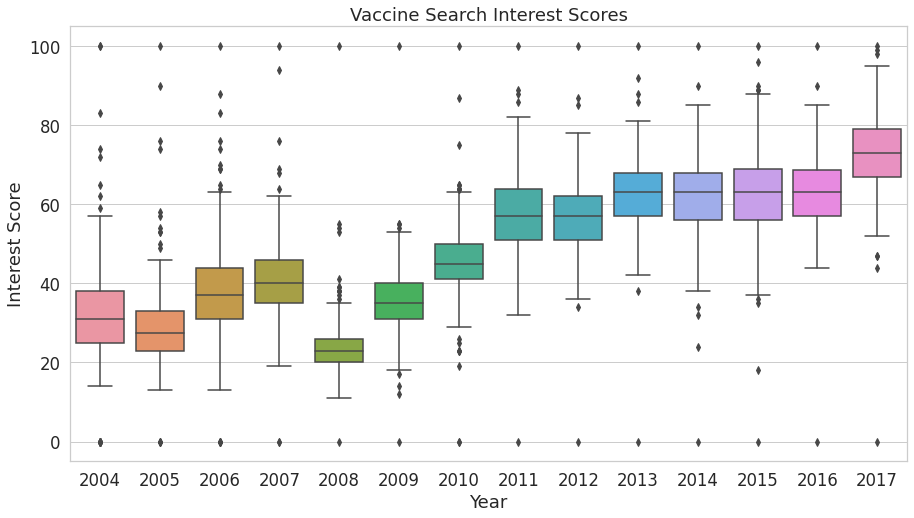

In [18]:
# Create a box plot for vaccine query
sns.set(font_scale=1.5)
sns.set_style('whitegrid')

fig = plt.gcf()
fig.set_size_inches(15, 8)
sns.boxplot("year", "value", data=melted_df)
plt.title('Vaccine Search Interest Scores')
plt.xlabel('Year')
plt.ylabel('Interest Score')

Text(10.2, 2.5, 'total n: 2940')

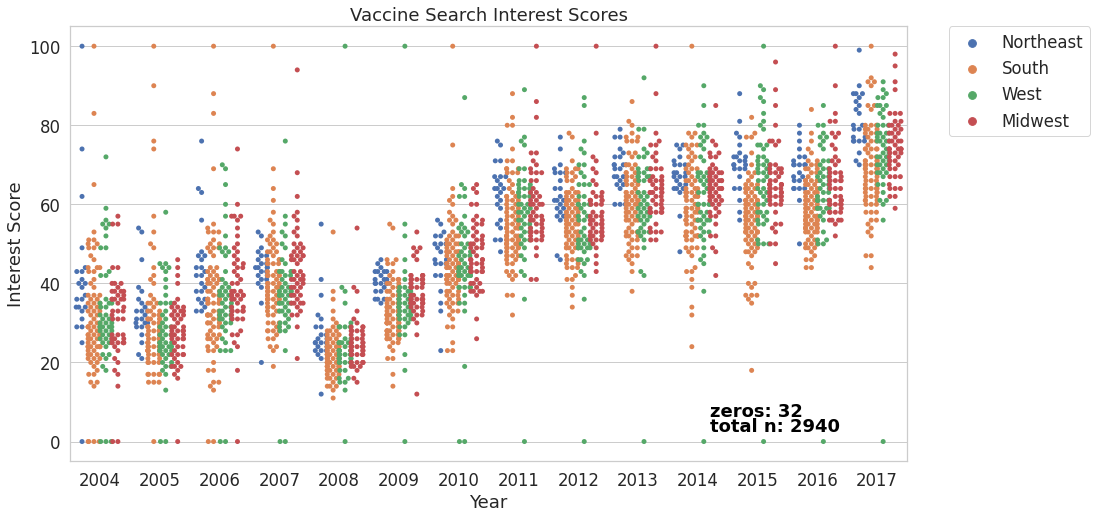

In [19]:
# Swarm plot
fig = plt.gcf()
fig.set_size_inches(15, 8)
ax = fig.add_subplot(111)

s = sns.swarmplot(x = 'year', y='value', hue='region', data=melted_df, dodge=True)
plt.title('Vaccine Search Interest Scores')
plt.xlabel('Year')
plt.ylabel('Interest Score')
# Place legend outside of plot
handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles[0:4], labels[0:4], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# Count the number of zeros and total number of data points
num_zeros = len(melted_df[melted_df.value == 0])
total_n = len(melted_df)
# Add counts text to plot
s.text(10+0.2, 6.5, "zeros: " + str(num_zeros), horizontalalignment='left', size='medium', color='black', weight='semibold')
s.text(10+0.2, 2.5, "total n: " + str(total_n), horizontalalignment='left', size='medium', color='black', weight='semibold')

Scores of 100 come from all regions, with the least number of 100 scores from the Northeast. There was only one instance of a 100 score in 2004 from the Northeast.

There were a total of 32 zero scores, which is 1.1% of the vaccine subset. Only a small percentage have a score of zero, so it is fine to omit zero scores.

In [20]:
# vacc_all dataframe, each row is a city
# Add 'state' column
vacc_all['state'] = healthSearchData['state_abbrev']
vacc_all.head()

,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,region,state
0,31,36,48,42,23,40,45,64,68,70,72,64,64,76,Northeast,ME
1,33,29,38,41,23,36,42,51,47,60,57,58,64,79,Northeast,NY
2,37,21,35,45,29,43,46,48,56,66,66,73,72,77,Northeast,NY
3,49,33,50,42,24,24,41,54,57,60,53,53,56,47,South,GA
4,36,33,42,47,27,40,49,67,62,69,68,69,70,84,Northeast,PA


In [21]:
# Count the number of entries/cities per state
#from collections import Counter

Counter(vacc_all.state)

Counter({'AK': 3,
         'AL': 4,
         'AR': 4,
         'AZ': 2,
         'CA': 12,
         'CO': 3,
         'CT': 1,
         'DC': 1,
         'FL': 9,
         'GA': 7,
         'HI': 1,
         'IA': 4,
         'ID': 3,
         'IL': 6,
         'IN': 6,
         'KS': 3,
         'KY': 3,
         'LA': 6,
         'MA': 2,
         'MD': 2,
         'ME': 3,
         'MI': 7,
         'MN': 3,
         'MO': 6,
         'MS': 6,
         'MT': 6,
         'NC': 5,
         'ND': 2,
         'NE': 4,
         'NH': 1,
         'NM': 1,
         'NV': 2,
         'NY': 10,
         'OH': 9,
         'OK': 4,
         'OR': 4,
         'PA': 6,
         'SC': 4,
         'SD': 2,
         'TN': 5,
         'TX': 17,
         'UT': 1,
         'VA': 6,
         'WA': 3,
         'WI': 6,
         'WV': 4,
         'WY': 1})

In [22]:
# Melt dataframe to have only columns 'region', 'state', 'year', and 'score'
melted_df = pd.melt(vacc_all, id_vars=['region','state'], var_name='year', value_name='score')
melted_df.head()

,region,state,year,score
0,Northeast,ME,2004,31
1,Northeast,NY,2004,33
2,Northeast,NY,2004,37
3,South,GA,2004,49
4,Northeast,PA,2004,36


In [0]:
# Remove zeros, and replace with nan, before calculating state mean score
melted_df = melted_df.replace(0, np.nan)

In [24]:
# Find the mean score for each state, in each year
grouped_df = melted_df.groupby(['year', 'state']).mean()
grouped_df.head()

score
year state           
2004 AK     32.000000
     AL     38.000000
     AR     31.500000
     AZ     30.500000
     CA     35.833333

In [25]:
# Reset index to make year and state columns
grouped_df.reset_index(inplace=True)
grouped_df.head()

,year,state,score
0,2004,AK,32.000000
1,2004,AL,38.000000
2,2004,AR,31.500000
3,2004,AZ,30.500000
4,2004,CA,35.833333


# Interactive Map With Slider


In [26]:
grouped_df.head()

,year,state,score
0,2004,AK,32.000000
1,2004,AL,38.000000
2,2004,AR,31.500000
3,2004,AZ,30.500000
4,2004,CA,35.833333


In [0]:
def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-latest.min.js?noext',
            },
          });
        </script>
        '''))
  configure_plotly_browser_state()

In [28]:
# Create slider
data_slider = []

for year in grouped_df.year.unique():
    # Select the year
    one_year = grouped_df[grouped_df.year == year]

    for col in grouped_df.columns:  # Transform the columns into string type
        one_year[col] = one_year[col].astype(str)

    ### Create the text for mouse-hover for each state, for the current year    
    one_year['text'] = one_year['state'] + '<br>Score: ' + one_year['score']

    ### Create the dictionary with the data for the current year
    data_one_year = dict(
                        type='choropleth',
                        locations = one_year['state'],
                        z=one_year['score'].astype(float),
                        locationmode='USA-states',
                        zmin=20,
                        zmax=100,
                        text = one_year['text'],
                        hoverinfo='text',
                        )

    data_slider.append(data_one_year)  # Add the dictionary to the list of dictionaries for the slider



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [0]:
# Create the steps for the slider

steps = []

for i in range(len(data_slider)):
    step = dict(method='restyle',
                args=['visible', [False] * len(data_slider)],
                label='Year {}'.format(i + 2004)) # label to be displayed for each step (year)
    step['args'][1][i] = True
    steps.append(step)


In [0]:
# Create the 'sliders' object from the 'steps' 

sliders = [dict(active=0, pad={"t": 1}, steps=steps)] 

In [0]:
#from plotly.offline import iplot

In [32]:
#set up the layout (including slider option)
layout = dict(geo=dict(scope='usa',
                       projection={'type': 'albers usa'},
                       showlakes=False),
              sliders=sliders)
	
# create the figure object:
fig = dict(data=data_slider, layout=layout) 

# plot 
iplot(fig)

Interest across the states drop during 2008, with a large increase from 2009-2011. While the Northeast had the least number of high 100 scores, the Northeast appears to consistently have high interest in vaccines compared to the South.

# Correlation Heat Maps


In [33]:
state_df = grouped_df.pivot(index='year', columns='state', values='score')
state_df.head()

state,AK,AL,AR,AZ,CA,CO,CT,DC,FL,GA,HI,IA,ID,IL,IN,KS,KY,LA,MA,MD,ME,MI,MN,MO,MS,MT,NC,ND,NE,NH,NM,NV,NY,OH,OK,OR,PA,SC,SD,TN,TX,UT,VA,WA,WI,WV,WY
year,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2004,32.000000,38.00,31.50,30.5,35.833333,25.333333,43.0,46.0,28.666667,35.142857,29.0,34.5,34.666667,35.166667,24.166667,38.000000,23.333333,28.200000,38.0,35.5,46.500000,34.333333,36.666667,30.000000,44.400000,52.25,34.8,33.0,33.666667,34.0,30.0,25.5,44.5,28.000000,38.25,39.25,40.333333,24.75,46.5,21.8,31.933333,21.0,33.166667,31.000000,33.833333,41.750000,27.0
2005,33.000000,27.00,27.75,29.5,27.250000,26.000000,35.0,42.0,21.666667,28.714286,19.0,31.5,23.000000,26.000000,30.166667,24.333333,25.333333,37.500000,31.0,29.0,45.333333,32.666667,34.333333,26.000000,49.166667,36.60,33.0,33.5,29.666667,31.0,29.0,21.0,32.1,23.777778,27.75,26.50,31.000000,27.00,34.0,25.6,34.176471,22.0,26.666667,27.000000,29.166667,21.333333,45.0
2006,43.000000,32.50,39.25,35.5,35.083333,32.666667,46.0,55.0,31.111111,36.285714,37.0,45.5,42.000000,36.000000,41.000000,40.666667,33.666667,50.000000,41.0,35.5,50.333333,38.333333,42.666667,39.333333,46.833333,53.40,38.4,49.5,32.000000,44.0,48.0,28.5,45.8,33.222222,23.75,41.00,40.500000,31.75,57.0,36.0,33.266667,31.0,39.833333,34.000000,44.833333,54.000000,23.0
2007,44.333333,35.75,30.00,35.5,33.083333,35.333333,47.0,52.0,38.111111,39.428571,33.0,43.5,39.666667,38.833333,43.333333,46.000000,44.000000,31.666667,43.5,57.0,43.000000,41.166667,48.666667,44.000000,49.500000,53.00,40.6,50.5,54.750000,44.0,49.0,34.5,41.0,40.222222,40.25,34.25,46.166667,40.25,43.5,40.0,39.941176,32.0,45.000000,42.000000,45.333333,41.250000,55.0
2008,24.333333,20.75,19.00,23.0,20.750000,24.333333,26.0,21.0,20.333333,20.428571,20.0,22.0,23.000000,24.666667,25.166667,21.000000,24.666667,20.666667,23.5,27.0,29.666667,36.857143,29.000000,22.666667,22.166667,27.40,25.8,27.5,31.500000,26.0,29.0,17.5,27.3,24.777778,18.00,24.50,28.500000,21.50,24.0,21.0,22.176471,20.0,24.500000,24.333333,25.166667,37.250000,18.0


Text(0.5, 1.0, 'Pearson Correlation Matrix of Mean Scores')

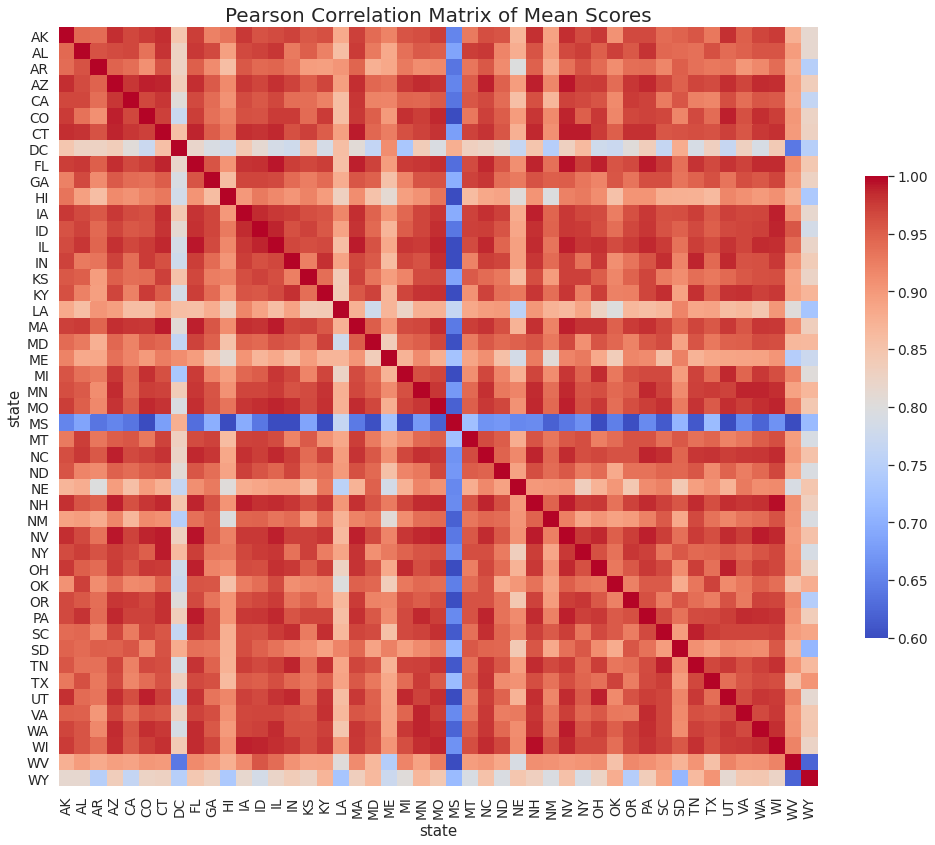

In [34]:
# Is there a correlation between states?
# Create a correlation / heat map

sns.set(font_scale=1.25)
# Create a correlation matrix of means
corr = state_df.corr(method='pearson')

# Seaborn heatmap
plt.figure(figsize=(17,17))
ax = sns.heatmap(
    corr, 
    vmin=0.6, vmax=1, center=0.8,
    cmap='coolwarm',
    square=True,
    robust=True,
    annot_kws={"size":10},
    cbar_kws={"shrink": 0.5}
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=90
);

plt.title('Pearson Correlation Matrix of Mean Scores', fontdict = {'fontsize' : 20})

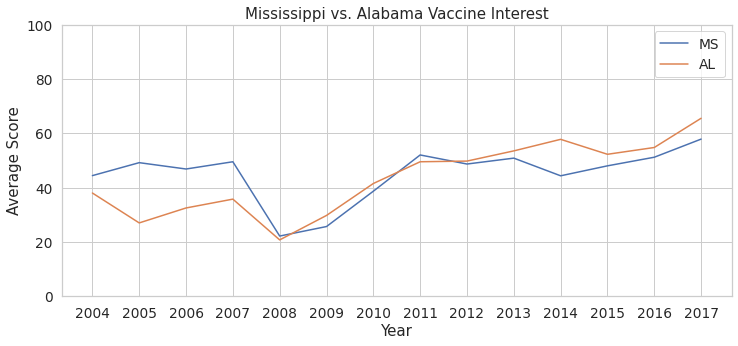

In [35]:
# What is going on with Mississippi, are the scores from MS really different from the other states?

MS = grouped_df[grouped_df.state == 'MS']
AL = grouped_df[grouped_df.state == 'AL']

# Plot MS mean scores over time
sns.set(font_scale=1.25)
sns.set_style('whitegrid')
plt.figure(figsize=(12,5))
plt.plot(MS.year, MS.score)
plt.plot(AL.year, AL.score)
plt.ylim(0,100)
plt.title('Mississippi vs. Alabama Vaccine Interest')
plt.xlabel('Year')
plt.ylabel('Average Score')
plt.legend(loc='best', labels=['MS', 'AL'])

In [36]:
vacc_all.head()

,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,region,state
0,31,36,48,42,23,40,45,64,68,70,72,64,64,76,Northeast,ME
1,33,29,38,41,23,36,42,51,47,60,57,58,64,79,Northeast,NY
2,37,21,35,45,29,43,46,48,56,66,66,73,72,77,Northeast,NY
3,49,33,50,42,24,24,41,54,57,60,53,53,56,47,South,GA
4,36,33,42,47,27,40,49,67,62,69,68,69,70,84,Northeast,PA


Text(0.5, 1.0, 'Pearson Correlation Matrix of Mean Scores')

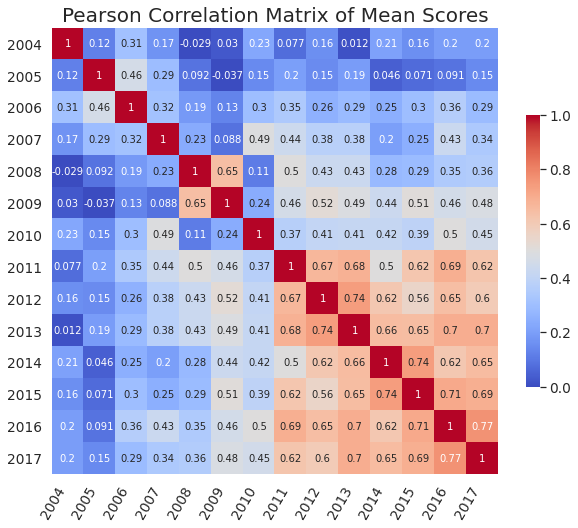

In [37]:
# Is there a correlation between years?
# Create a correlation / heat map

sns.set(font_scale=1.25)
# Create a correlation matrix of means
corr = vacc_all.corr(method='pearson')

# Seaborn heatmap
plt.figure(figsize=(10,10))
ax = sns.heatmap(
    corr, 
    vmin=0, vmax=1, center=0.5,
    cmap='coolwarm',
    square=True,
    robust=True,
    annot=True,
    annot_kws={"size":10},
    cbar_kws={"shrink": 0.5}
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=60,
    horizontalalignment='right'
);

plt.title('Pearson Correlation Matrix of Mean Scores', fontdict = {'fontsize' : 20})

The data has low correlation from 2004-2010, with increasing correlation for years 2011-2017.

# Machine Learning / Predictive Analysis


In [38]:
grouped_df.head()

,year,state,score
0,2004,AK,32.000000
1,2004,AL,38.000000
2,2004,AR,31.500000
3,2004,AZ,30.500000
4,2004,CA,35.833333


In [176]:
# Subset California data
ca_df = grouped_df[grouped_df.state == 'CA']
ca_df = ca_df.drop('state', axis=1)
ca_df.head()

,year,score
4,2004,35.833333
51,2005,27.250000
98,2006,35.083333
145,2007,33.083333
192,2008,20.750000


Text(0, 0.5, 'Mean Score')

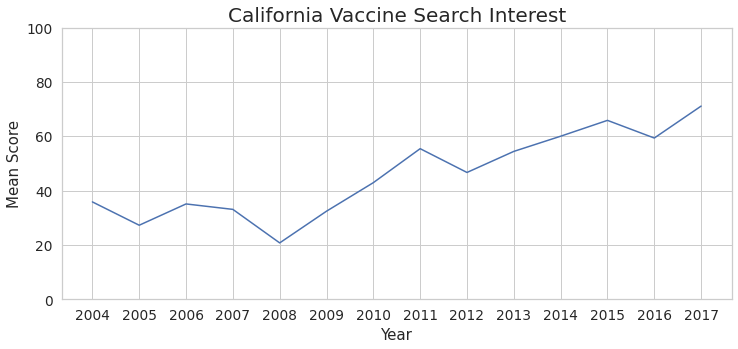

In [177]:
sns.set(font_scale=1.25)
sns.set_style("whitegrid")

plt.figure(figsize=(12,5))
ax = plt.subplot(111)

plt.plot(ca_df.year, ca_df.score)
plt.ylim(0,100)
plt.title("California Vaccine Search Interest", fontsize=20)
plt.xlabel('Year')
plt.ylabel('Mean Score')

In [178]:
# Use datetime formatting
ca_df['year'] = pd.to_datetime(ca_df['year'], format="%Y")
# Rename column 'year' to 'date'
ca_df.columns = ['date', 'score']
ca_df.head()

,date,score
4,2004-01-01,35.833333
51,2005-01-01,27.250000
98,2006-01-01,35.083333
145,2007-01-01,33.083333
192,2008-01-01,20.750000


In [179]:
ca_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14 entries, 4 to 615
Data columns (total 2 columns):
date     14 non-null datetime64[ns]
score    14 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 336.0 bytes


In [180]:
# Set year as index
ca_df.set_index('date', inplace=True)
ca_df.head()

,score
date,
2004-01-01,35.833333
2005-01-01,27.250000
2006-01-01,35.083333
2007-01-01,33.083333
2008-01-01,20.750000


In [181]:
# Interpolate to increase 
interp_df = ca_df.resample('M').mean().interpolate(method='linear')
interp_df.head(13)

,score
date,
2004-01-31,35.833333
2004-02-29,35.118056
2004-03-31,34.402778
2004-04-30,33.687500
2004-05-31,32.972222
2004-06-30,32.256944
2004-07-31,31.541667
2004-08-31,30.826389
2004-09-30,30.111111


In [0]:
# Calculate the rolling statistics with window using 3 observations
roll_mean = interp_df.rolling(window=3).mean()
roll_sd = interp_df.rolling(window=3).std()
#roll_mean.head()

In [183]:
interp_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 157 entries, 2004-01-31 to 2017-01-31
Freq: M
Data columns (total 1 columns):
score    157 non-null float64
dtypes: float64(1)
memory usage: 2.5 KB


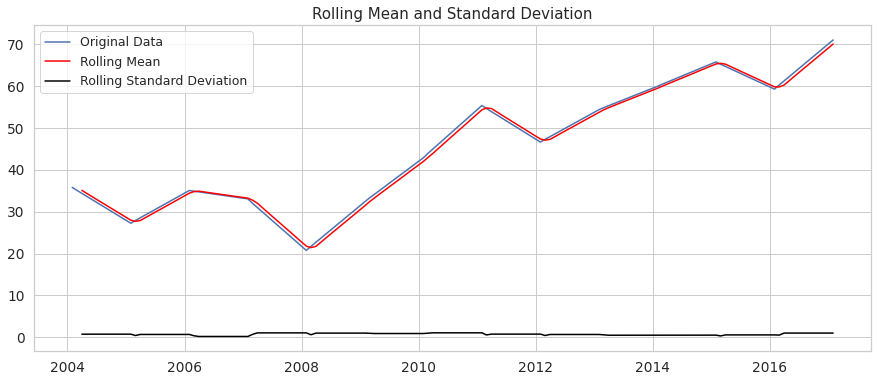

In [184]:
# Plot the data with rolling stats
plt.figure(figsize=(15,6))

plt.plot(interp_df, label='Original Data')
plt.plot(roll_mean, color='red', label='Rolling Mean')
plt.plot(roll_sd, color='black', label='Rolling Standard Deviation')
plt.title("Rolling Mean and Standard Deviation")
plt.legend(loc='best', fontsize='small')

In [185]:
# Dickey-Fuller test
# from statsmodels.tsa.stattools import adfuller

dftest = adfuller(interp_df['score'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 'n_lags', 'n_observations'])

for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value

print(dfoutput)

Test Statistic           -0.389136
p-value                   0.911897
n_lags                   13.000000
n_observations          143.000000
Critical Value (1%)      -3.476927
Critical Value (5%)      -2.881973
Critical Value (10%)     -2.577665
dtype: float64


In [0]:
def test_stationarity(timeseries):
    # Calculate the rolling statistics with window using 3 observations
    roll_mean = timeseries.rolling(window=3).mean()
    roll_sd = timeseries.rolling(window=3).std()
    # Plot
    plt.figure(figsize=(15,6))
    plt.plot(timeseries, label='Data')
    plt.plot(roll_mean, color='red', label='Rolling Mean')
    plt.plot(roll_sd, color='black', label='Rolling Standard Deviation')
    plt.title("Rolling Mean and Standard Deviation")
    plt.legend(loc='best', fontsize='small')

    # Dickey-Fuller test
    dftest = adfuller(timeseries['score'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 'n_lags', 'n_observations'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [0]:
# Create 1st and 2nd order differences

diff = interp_df.diff()
diff.dropna(inplace=True)

diff2 = interp_df.diff().diff()
diff2.dropna(inplace=True)

log_df = np.log(interp_df)
log_diff = log_df - log_df.shift()
log_diff.dropna(inplace=True)


Test Statistic           -2.402649
p-value                   0.140990
n_lags                   12.000000
n_observations          143.000000
Critical Value (1%)      -3.476927
Critical Value (5%)      -2.881973
Critical Value (10%)     -2.577665
dtype: float64


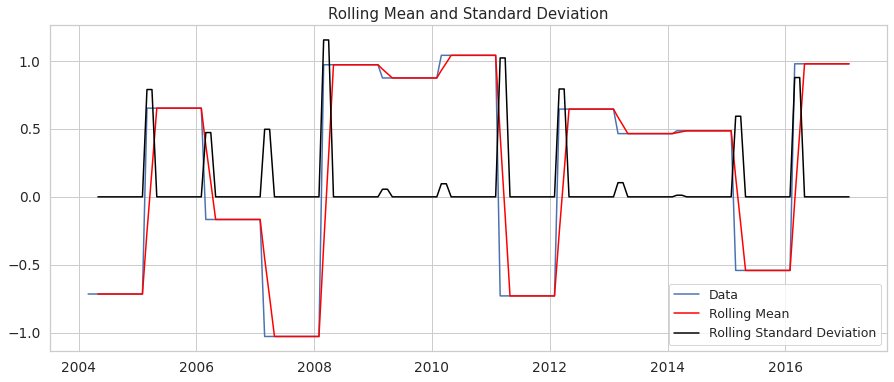

In [188]:
test_stationarity(diff)

Test Statistic         -6.089455e+00
p-value                 1.044985e-07
n_lags                  1.100000e+01
n_observations          1.430000e+02
Critical Value (1%)    -3.476927e+00
Critical Value (5%)    -2.881973e+00
Critical Value (10%)   -2.577665e+00
dtype: float64


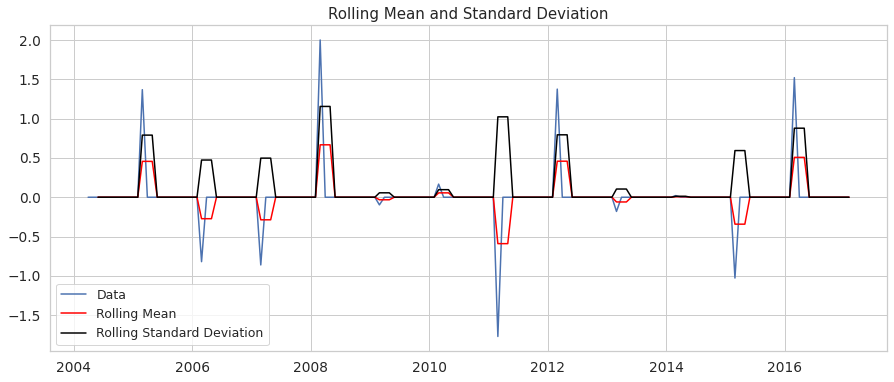

In [189]:
test_stationarity(diff2)

Test Statistic           -3.199541
p-value                   0.020011
n_lags                    0.000000
n_observations          155.000000
Critical Value (1%)      -3.473259
Critical Value (5%)      -2.880374
Critical Value (10%)     -2.576812
dtype: float64


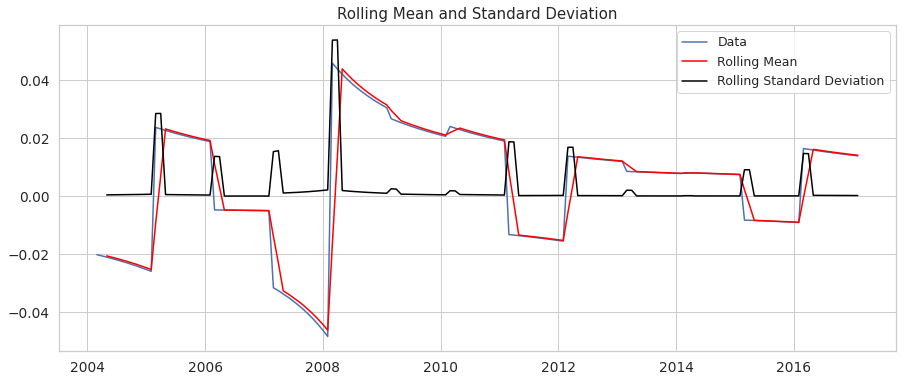

In [190]:
test_stationarity(log_diff)

## Tuning ARIMA parameters

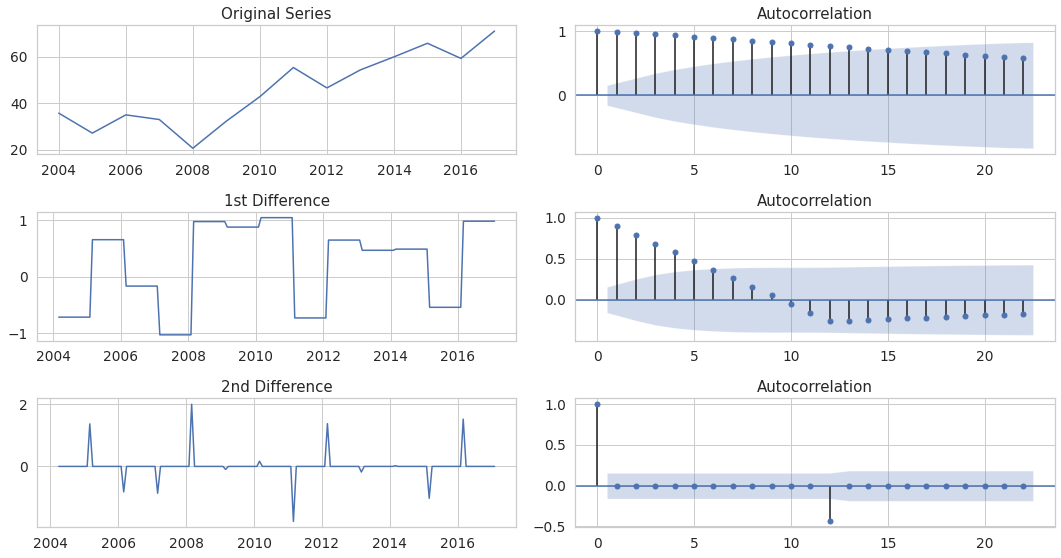

In [191]:
# Plot Data, Residuals and ACF functions
#from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# Original Series
fig, ax = plt.subplots(3, 2, figsize=(15,8))
plot = ax[0,0].plot(ca_df)
ax[0,0].set_title('Original Series')
acf=plot_acf(interp_df, ax=ax[0,1])

plot2 = ax[1,0].plot(diff)
ax[1,0].set_title('1st Difference')
acf2=plot_acf(diff, ax=ax[1,1])

plot3 = ax[2,0].plot(diff2)
ax[2,0].set_title('2nd Difference')
acf2=plot_acf(diff2, ax=ax[2,1])

plt.tight_layout()


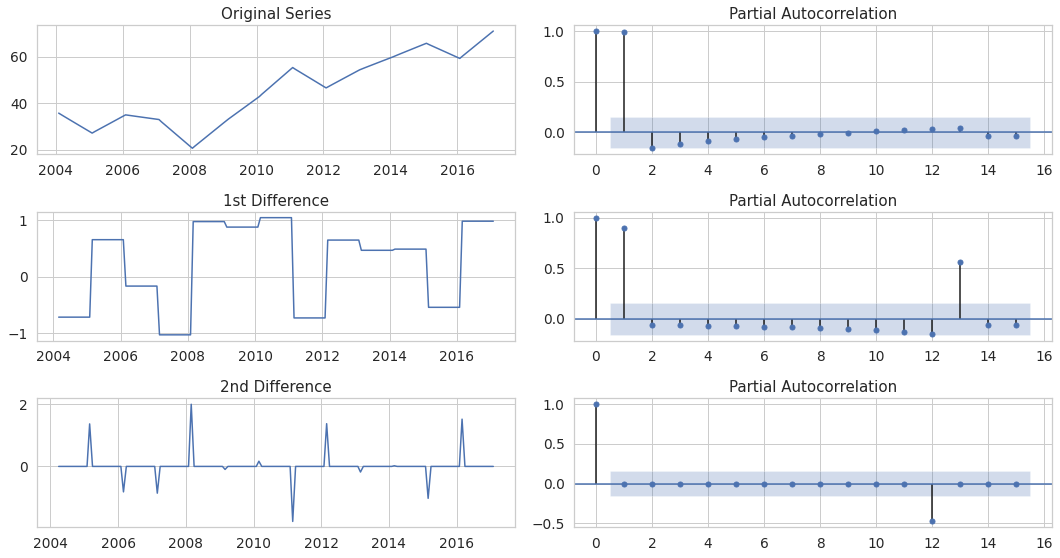

In [192]:
# Original Series
fig, ax = plt.subplots(3, 2, figsize=(15,8))
plot = ax[0,0].plot(interp_df)
ax[0,0].set_title('Original Series')
pacf=plot_pacf(interp_df, lags=15, ax=ax[0,1])
#pacf = plot_pacf(ca_df, lags=15)

plot2 = ax[1,0].plot(diff)
ax[1,0].set_title('1st Difference')
pacf2=plot_pacf(diff, lags=15, ax=ax[1,1])

plot3 = ax[2,0].plot(diff2)
ax[2,0].set_title('2nd Difference')
pacf2=plot_pacf(diff2, lags=15, ax=ax[2,1])

plt.tight_layout()

Try using 1 lag for parameter p, since the first lag is outside of significance bounds.

In [193]:
# ARIMA (Autoregressive Integrated Moving Average) model is used for timeseries forecasting

#from statsmodels.tsa.arima_model import ARIMA
# Fit model
model = ARIMA(interp_df, order=(1,1,5)) # (p,d,q) -> p = lag value for autoregression, d = difference order, q = size of moving average window
results_AR = model.fit(disp=-1, )
print(results_AR.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.score   No. Observations:                  156
Model:                 ARIMA(1, 1, 5)   Log Likelihood                 -39.335
Method:                       css-mle   S.D. of innovations              0.310
Date:                Thu, 26 Mar 2020   AIC                             94.671
Time:                        21:40:40   BIC                            119.069
Sample:                    02-29-2004   HQIC                           104.580
                         - 01-31-2017                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.2188      0.213      1.028      0.305      -0.198       0.636
ar.L1.D.score     0.8522      0.069     12.379      0.000       0.717       0.987
ma.L1.D.score     0.0881      0.105     

The AIC score is 94.671, and we will compare this value with other orders of the ARIMA model. Minimizing the AIC score equates to a better fit model.

In [194]:
# Loop through values for parameters p,d,q to determine which model produces the lowest AIC

# Print warnings only once
#import warnings
warnings.filterwarnings(action='once')

ps = [0,1,2,3,4,5]
ds=[0,1,2]
qs = [0,1,2,3,4,5]
best_aic = 100
best_p = 0
best_d = 0
best_q = 0
for p in ps:
  for d in ds:
    for q in qs:
      try: 
        model = ARIMA(interp_df, order=(p,d,q)) # (p,d,q) -> p = lag value for autoregression, d = difference order, q = size of moving average window
        results_AR = model.fit(disp=-1)
        aic = results_AR.aic
        if aic < best_aic:
          best_p = p
          best_d = d
          best_q = q
          best_aic = aic
          print(p,d, q, aic)
      except:
        pass

'The best p,d,q = {}, {}, {}, with AIC = {}'.format(best_p, best_d, best_q, best_aic)

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available



0 1 5 94.5186624469294
0 2 0 89.27360855778488
1 1 0 86.30165771430438


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



2 1 1 85.1561246824366


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning:

overflow encountered in exp

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:695: RuntimeWarning:

invalid value encountered in log



3 1 2 84.59401010592819
4 1 4 84.4057305505412


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:695: RuntimeWarning:

divide by zero encountered in log

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/numdiff.py:243: RuntimeWarning:

invalid value encountered in subtract

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/numdiff.py:243: RuntimeWarning:

invalid value encountered in multiply

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning:

invalid value encountered in exp

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:693: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:695: RuntimeWarning:

divide by zero encountered in true_divide

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:693: RuntimeWarning:

divide by zero encountered in double_scalars



5 1 3 84.31766720848515
5 1 4 81.36595071570457


'The best p,d,q = 5, 1, 4, with AIC = 81.36595071570457'

In [195]:
print(best_p, best_d, best_q)

5 1 4


The best model has order (5,1,4) and an AIC score of 81.366, which is significantly lower than the first model with order (1,1,5). ARIMA model (5,1,4) will be used to fit the California subset of scores.

In [196]:
# Fit model
model = ARIMA(interp_df, order=((5,1,3))) # (p,d,q) -> p = lag value for autoregression, d = difference order, q = size of moving average window
results_AR = model.fit(disp=-1)
print(results_AR.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.score   No. Observations:                  156
Model:                 ARIMA(5, 1, 3)   Log Likelihood                 -32.159
Method:                       css-mle   S.D. of innovations              0.289
Date:                Thu, 26 Mar 2020   AIC                             84.318
Time:                        21:43:32   BIC                            114.816
Sample:                    02-29-2004   HQIC                            96.705
                         - 01-31-2017                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.2698      0.042      6.422      0.000       0.187       0.352
ar.L1.D.score     0.2387      0.081      2.935      0.004       0.079       0.398
ar.L2.D.score     1.3100      0.084     

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available



In [197]:
# Fit model
model = ARIMA(interp_df, order=(best_p, best_d, best_q)) # (p,d,q) -> p = lag value for autoregression, d = difference order, q = size of moving average window
results_AR = model.fit(disp=-1)
print(results_AR.summary())

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available



                             ARIMA Model Results                              
Dep. Variable:                D.score   No. Observations:                  156
Model:                 ARIMA(5, 1, 4)   Log Likelihood                 -29.683
Method:                       css-mle   S.D. of innovations              0.283
Date:                Thu, 26 Mar 2020   AIC                             81.366
Time:                        21:43:38   BIC                            114.914
Sample:                    02-29-2004   HQIC                            94.992
                         - 01-31-2017                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.2670      0.046      5.845      0.000       0.177       0.356
ar.L1.D.score     0.0151      0.078      0.194      0.846      -0.137       0.167
ar.L2.D.score     0.9388      0.071     

The best AIC scores are given when using ARIMA orders of (5,1,4) and (5,1,3). The scores are 81.366 and 84.318 respectively. Both of these scores are significantly better than the initial model with order (1,1,5).

Looking at the p-values of coefficients, the first model with order (5,1,4) has p-values of 0 except for 2 p-values greater than 0.8 for an autoregressive and moving average coefficient. The order (5,1,4) model also resulted in p-values of 0 except for 2 p-values between 0.1 and 0.45. Both models have a couple of coefficients that are not playing a significant part in the model.

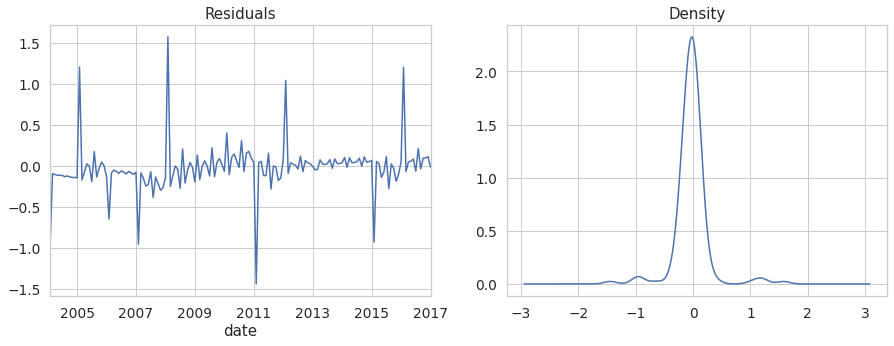

In [198]:
# Plot residual errors
residuals = pd.DataFrame(results_AR.resid)
fig, ax = plt.subplots(1,2,figsize=(15,5))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
# Remove y-label and legends
for ax in ax.flat:
    ax.set(ylabel='')
    ax.get_legend().remove()
plt.show()

The residuals look okay, with bigger spikes at the turn of each year due to using annal average scores, and interpolating linearly between years by month. Residual errors are roughly Gaussian and slightly skewed.

In [200]:
# Residual stats
residuals.describe()

,0
count,156.000000
mean,-0.024889
std,0.299852
min,-1.441196
25%,-0.117960
50%,-0.017618
75%,0.054263
max,1.575396


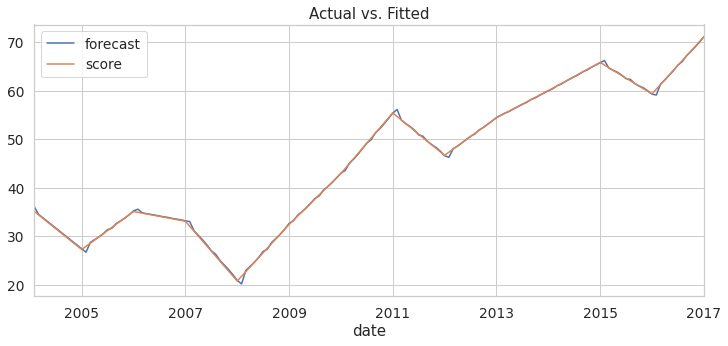

In [201]:
# Actual vs Fitted
with plt.rc_context():
    plt.rc("figure", figsize=(12,5))
    results_AR.plot_predict(dynamic=False)
plt.title('Actual vs. Fitted')
plt.show()

## Evaluate Model Performance

In [202]:
# Split the timeseries into contiguous training and test datasets with a 75:25 ratio
split = int(len(interp_df)*.80)
train = interp_df[0:split]
len(train)

125

In [203]:
test = interp_df[split:]
len(test)

32

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available



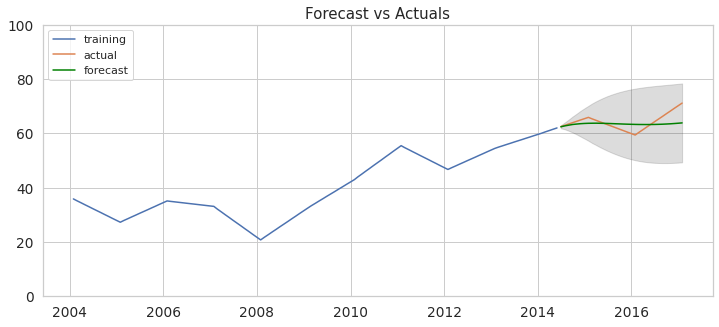

In [204]:
#from numpy.linalg import LinAlgError

# Build Model  
try:
  model = ARIMA(train, order=(best_p, best_d, best_q)) 
  #model = ARIMA(train, order=(5,1,3))  
  fitted = model.fit(disp=-1)  
except (ValueError, LinAlgError):
  pass

# Forecast
fc, se, conf = fitted.forecast(len(test), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5))
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast', color='green')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.ylim(0,100)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=11)
plt.show()

In [0]:
def squared_error(true, predicted):
  """ Finds the squared error between two points: true value and predicted value """
  squared_err = (true - predicted)**2
  return squared_err

In [206]:
# End of forecast root squared error
np.sqrt(squared_error(test.score[-1], fc_series[-1]))

7.285088230019092

In [207]:
# Find the Mean Squared Error for all data in test and forecasted series
#from sklearn.metrics import mean_squared_error
error = mean_squared_error(test, fc_series)
print('Total Test MSE: %.3f' % error)

Total Test MSE: 7.843


MSE between the test set and forecasted set is:
7.843 with ARIMA order (5,1,4), and
8.533 with order (5,1,3).

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning:

overflow encountered in exp

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning:

invalid value encountered in true_divide



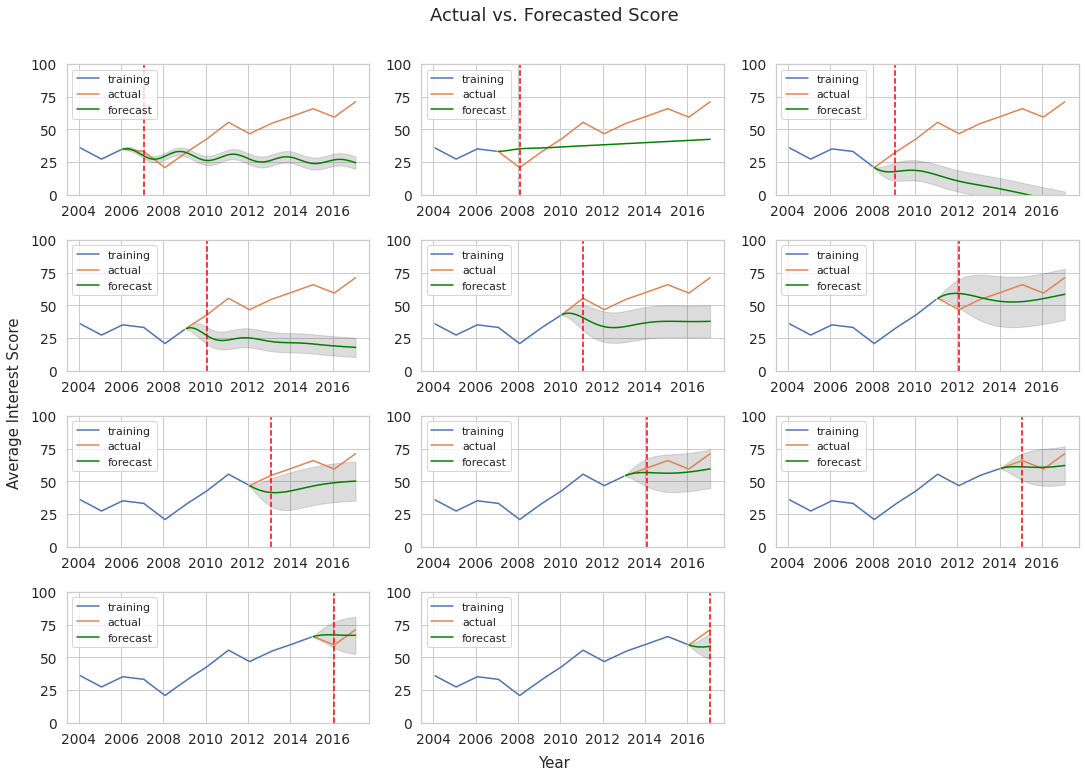

In [208]:
# Evaluate model performance for one year forecasts.
# Create 4x3 subplots
# Calculate the root mean squared error (RMSE) of each 1 year forecast for the years 2007 through 2017. 
# Then print output the mean RMSE.

# Create range of indices to split data on - splits yearly on January
splits = range(24,156,12)
all_rmse = []
fig = plt.figure(figsize=(15,10))

for i in range(len(splits)):
  train = interp_df[0:splits[i]]
  test = interp_df[splits[i]:]
  # Build Model  
  try:
    model = ARIMA(train, order=(best_p, best_d, best_q))  
    fitted = model.fit(disp=-1)  
  except (ValueError, LinAlgError):
    pass

  # Forecast
  fc, se, conf = fitted.forecast(len(test), alpha=0.05)  # 95% conf

  # Make as pandas series
  fc_series = pd.Series(fc, index=test.index)
  lower_series = pd.Series(conf[:, 0], index=test.index)
  upper_series = pd.Series(conf[:, 1], index=test.index)

  # Calculate Root Mean Squared Error
  se = squared_error(test.score[12], fc_series[12])
  rmse = np.sqrt(se)
  #print('The root mean squared error for 1 year forecast is', rmse)
  all_rmse.append(rmse)

  ax = fig.add_subplot(4,3,i+1)
  plt.plot(train, label='training')
  plt.plot(test, label='actual')
  plt.plot(fc_series, label='forecast', color='green')
  plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
  plt.ylim(0,100)
  # Vertical line to highlight 1 year prediction vs. actual score
  plt.axvline(test.index[12], color='red', linestyle='--')
  plt.legend(loc='upper left', fontsize=11)
  #plt.annotate('RMSE =' + str(rmse), (1,1))
  #ax.annotate('RMSE =' + str(rmse), xy=(0.5,0.5))
  
fig.suptitle('Actual vs. Forecasted Score', y=1.05, fontsize='large')
# Set common labels
fig.text(0.5, 0.0, 'Year', ha='center', va='center', fontsize='medium')
fig.text(0.0, 0.5, 'Average Interest Score', ha='center', va='center', rotation='vertical', fontsize='medium')
plt.tight_layout()

In [209]:
np.mean(all_rmse)

10.688652380747168

In [211]:
# Create a dataframe of years and corresponding rmse
predicted_years = np.arange(2007, 2018)
rmse_df = pd.DataFrame({'year': predicted_years, 'rmse':all_rmse})
rmse_df.set_index('year', inplace=True)
#print(rmse_df)
rmse_df.T

year,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
rmse,3.433086,14.348196,14.686348,16.251884,14.917518,12.397928,13.001132,3.337338,4.798859,7.753561,12.649324


(5,1,4) model: The mean squared error for all 1 year forecasts is 10.688652380747168

(5,1,3) model: The mean squared error for all 1 year forecasts is 10.24651994443601

When comparing the 1-year forecasts the ARIMA model with order (5,1,3) performs slightly better.

## Forecasting

In [138]:
model = ARIMA(interp_df, order=(best_p, best_d, best_q)) # (p,d,q) -> p = lag value for autoregression, d = difference order, q = size of moving average window
results_AR = model.fit(disp=-1)

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available



In [0]:
def plot_forecast(n_months=12):
  """ Plot ARIMA forecast, n_months after January 2017 """
  # Create new indices for forecast
  end = interp_df.index[-1]
  new_inds = end + np.arange(n_months) + 1
  # Forecast using fitted model
  fc, se, conf = results_AR.forecast(n_months, alpha=0.05)  # 95% conf
  # Make as pandas series
  fc_series = pd.Series(fc, index=new_inds)
  lower_series = pd.Series(conf[:, 0], index=new_inds)
  upper_series = pd.Series(conf[:, 1], index=new_inds)
  # Plot
  plt.figure(figsize=(12,5))
  plt.plot(interp_df, label='training')
  plt.plot(fc_series, label='forecast', color='green')
  plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
  plt.ylim(0,100)
  plt.title('Forecast')
  plt.xlabel('Year')
  plt.ylabel('Mean Interest Score')
  plt.legend(loc='upper left', fontsize=11)
  plt.show()
  print('The predicted score at end of forecast is =', fc_series[-1])
  return fc_series

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning:

Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`



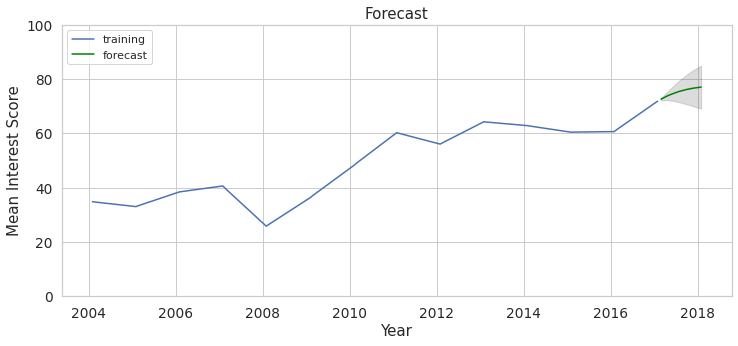

The predicted score at end of forecast is = 76.97420983870775


In [150]:
fc = plot_forecast(12)

In [140]:
fc[-1:]

array([64.2748348])

In [79]:
interp_df.tail()

,score
date,
2016-09-30,67.166667
2016-10-31,68.145833
2016-11-30,69.125000
2016-12-31,70.104167
2017-01-31,71.083333


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning:

Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`



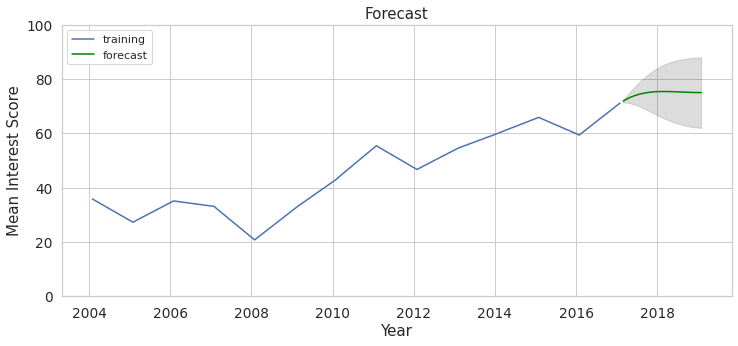

The predicted score at end of foreast is = 74.96297916236912


In [80]:
fc = plot_forecast(n_months=24)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning:

Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`



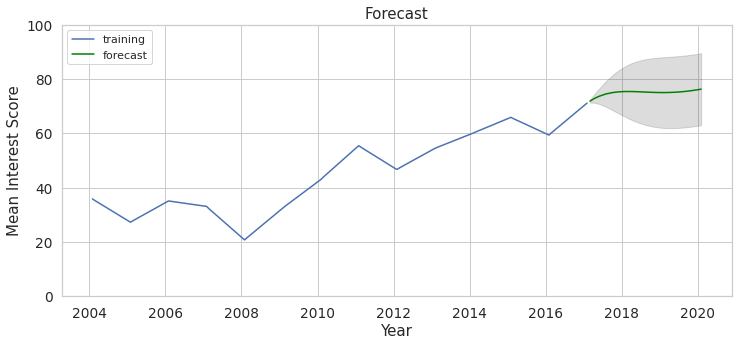

The predicted score at end of foreast is = 76.21498048774403


In [82]:
fc = plot_forecast(n_months=36)

## Automation for All States

In [84]:
grouped_df.head()

,year,state,score
0,2004,AK,32.000000
1,2004,AL,38.000000
2,2004,AR,31.500000
3,2004,AZ,30.500000
4,2004,CA,35.833333


In [85]:
len(set(grouped_df.state))

47

In [0]:
def get_state_subset(state_abbrev): 
  """ Gets a subset for the state, input is the two letter state abbreviation as a string """
  state_df = grouped_df[grouped_df.state == state_abbrev]
  state_df = state_df.drop('state', axis=1)
  return state_df

In [0]:
def interpolate_df(df):
  """ Converts year column into datetime object, and then upsamples by month and interpolates linearly """
  # Use datetime formatting
  df['year'] = pd.to_datetime(df['year'], format="%Y")
  # Rename column 'year' to 'date'
  df.columns = ['date', 'score']
  df.set_index('date', inplace=True)
  interp_df = df.resample('M').mean().interpolate(method='linear')
  return interp_df

In [0]:
def get_best_model(interpolated_df):
  """ Fits model to interpolated dataframe, and returns the best parameters for p,d,q, along with the fitted ARIMA model. """
  ps = [0,1,2,3,4,5]
  ds=[0,1,2]
  qs = [0,1,2,3,4,5]
  best_aic = 500
  best_p = 0
  best_d = 0
  best_q = 0
  for p in ps:
    for d in ds:
      for q in qs:
        try: 
          model = ARIMA(interpolated_df, order=(p,d,q)) # (p,d,q) -> p = lag value for autoregression, d = difference order, q = size of moving average window
          fitted_AR = model.fit(disp=-1)
          aic = fitted_AR.aic
          if aic < best_aic:
            best_p = p
            best_d = d
            best_q = q
            best_aic = aic
            #print(p,d, q, aic)
        except:
          pass
  model = ARIMA(interpolated_df, order=(best_p,best_d,best_q))
  best_fitted = model.fit(disp=-1)
  return best_p, best_d, best_q, best_fitted

In [0]:
def one_yr_forecast(interp_df, fitted_model, n_months=12):
  """ Forecast, returns the forecasted value n_months after January 2017.
  The default function will return a 12 month / 1 year forecast value. """
  # Create new indices for forecast
  end = interp_df.index[-1]
  new_inds = end + np.arange(n_months) + 1
  # Forecast using fitted model
  fc, se, conf = fitted_model.forecast(n_months, alpha=0.05)  # 95% conf
  # Make as pandas series
  fc_series = pd.Series(fc, index=new_inds)
  #lower_series = pd.Series(conf[:, 0], index=new_inds)
  #upper_series = pd.Series(conf[:, 1], index=new_inds)

  print('The predicted score at end of forecast is =', fc_series[-1])
  return fc_series[-1]

In [0]:
def plot_forecast_2(interp_df, fitted_model, n_months=12):
  """ Plot ARIMA forecast, n_months after January 2017 """
  # Create new indices for forecast
  end = interp_df.index[-1]
  new_inds = end + np.arange(n_months) + 1
  # Forecast using fitted model
  fc, se, conf = fitted_model.forecast(n_months, alpha=0.05)  # 95% conf
  # Make as pandas series
  fc_series = pd.Series(fc, index=new_inds)
  lower_series = pd.Series(conf[:, 0], index=new_inds)
  upper_series = pd.Series(conf[:, 1], index=new_inds)
  # Plot
  plt.figure(figsize=(12,5))
  plt.plot(interp_df, label='training')
  plt.plot(fc_series, label='forecast', color='green')
  plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
  plt.ylim(0,100)
  plt.title('Forecast')
  plt.xlabel('Year')
  plt.ylabel('Mean Interest Score')
  plt.legend(loc='upper left', fontsize=11)
  plt.show()
  print('The predicted score at end of forecast is =', fc_series[-1])
  return fc_series

In [157]:
state_df = get_state_subset('NC')
state_df.head()

,year,score
26,2004,34.8
73,2005,33.0
120,2006,38.4
167,2007,40.6
214,2008,25.8


In [158]:
interp_df = interpolate_df(state_df)
interp_df.head()

,score
date,
2004-01-31,34.80
2004-02-29,34.65
2004-03-31,34.50
2004-04-30,34.35
2004-05-31,34.20


In [162]:
p,d,q,fitted_AR = get_best_model(interp_df)
print(p,d,q)

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning:

overflow encountered in exp

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:695: RuntimeWarning:

invalid value encountered in log

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:695: RuntimeWarning:

divide by zero encountered in true_divide

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:693: RuntimeWarning:

invalid value encountered in double_scalars



5 1 4


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning:

Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`



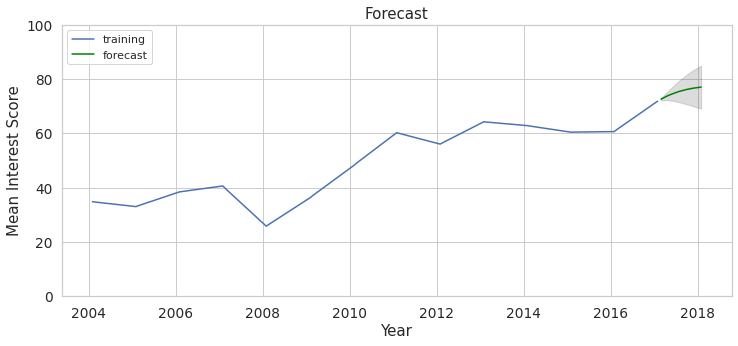

The predicted score at end of forecast is = 76.97420983870775


In [163]:
fc = plot_forecast_2(interp_df, fitted_AR, n_months=12)

In [164]:
one_yr_forecast(interp_df, fitted_AR, n_months=12)

The predicted score at end of forecast is = 76.97420983870775


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: FutureWarning:

Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`



2017-02-28    72.509024
2017-03-31    73.228659
2017-04-30    73.876209
2017-05-31    74.426459
2017-06-30    74.905210
2017-07-31    75.387815
2017-08-31    75.728249
2017-09-30    76.072583
2017-10-31    76.362524
2017-11-30    76.591554
2017-12-31    76.784489
2018-01-31    76.974210
dtype: float64

In [145]:
nc = get_state_subset('NC')
nc_interp = interpolate_df(nc)
p,d,q,fitted = get_best_model(nc_interp)
nc_fc = one_yr_forecast(nc_interp, fitted)


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning:

overflow encountered in exp

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:695: RuntimeWarning:

invalid value encountered in log

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:695: RuntimeWarning:

divide by zero encountered in true_divide

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:693: RuntimeWarning:

invalid value encountered in double_scalars



The predicted score at end of foreast is = 146.69418725918845


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: FutureWarning:

Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`



In [166]:
#import time

predicted_df = pd.DataFrame(columns=['year', 'state', 'score']) # Initialize dataframe to collect predictions
predicted_yrs = [2018] # Year(s) to predict

# A loop to find the predicted value for all states in predicted_yrs (2018)
start = time.time() # Time the loop
for state in set(grouped_df.state):
  for yr in predicted_yrs:
    state_df = get_state_subset(state) # Get the subset for each state
    interp_df = interpolate_df(state_df) # Interpolate the subset
    p,d,q,fitted_AR = get_best_model(interp_df) # Get the best fit model and parameters (p,d,q)
    fc = one_yr_forecast(interp_df, fitted_AR, n_months=12) # Get the 1 year forecasted value
    predicted_df = predicted_df.append({'year':yr, 'state':state, 'score':fc}, ignore_index=True)

print("Total time taken this loop: ", time.time() - start) # Print the time it takes to complete the loop

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:695: RuntimeWarning:

divide by zero encountered in true_divide

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning:

overflow encountered in exp

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:693: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:695: RuntimeWarning:

invalid value encountered in log

/usr/local/lib/python3.6/dist-packages/statsmo

The predicted score at end of forecast is = 70.43513321598164


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/numdiff.py:243: RuntimeWarning:

invalid value encountered in subtract

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/numdiff.py:243: RuntimeWarning:

invalid value encountered in multiply

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning:

invalid value encountered in exp



The predicted score at end of forecast is = 80.40196921470604


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:221: RuntimeWarning:

divide by zero encountered in true_divide



The predicted score at end of forecast is = 74.13703383186497
The predicted score at end of forecast is = 84.00537152091098
The predicted score at end of forecast is = 75.18065192924536
The predicted score at end of forecast is = 78.05216695215768
The predicted score at end of forecast is = 72.41439817436297
The predicted score at end of forecast is = 74.6277260308962
The predicted score at end of forecast is = 77.23935726116567
The predicted score at end of forecast is = 70.95052425863065
The predicted score at end of forecast is = 85.12564094201247
The predicted score at end of forecast is = 84.68373931430982
The predicted score at end of forecast is = 81.4943959115698
The predicted score at end of forecast is = 84.34236997574209
The predicted score at end of forecast is = 74.88919416928461
The predicted score at end of forecast is = 86.8377420797951
The predicted score at end of forecast is = 83.31805764557248
The predicted score at end of forecast is = 91.72577550565389
The predict

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:651: RuntimeWarning:

divide by zero encountered in arctanh



The predicted score at end of forecast is = 96.15670655202855


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:693: RuntimeWarning:

divide by zero encountered in double_scalars



The predicted score at end of forecast is = 74.76003933425848
The predicted score at end of forecast is = 90.03749413028673
The predicted score at end of forecast is = 71.61318351067393
The predicted score at end of forecast is = 74.15225606242264
The predicted score at end of forecast is = 91.50499912052463
The predicted score at end of forecast is = 77.14766415408957
The predicted score at end of forecast is = 58.62282385264492
The predicted score at end of forecast is = 76.97420983870775
The predicted score at end of forecast is = 78.25168176600991
The predicted score at end of forecast is = 78.69204141802072
The predicted score at end of forecast is = 77.49937639841373
The predicted score at end of forecast is = 75.34557103339738
The predicted score at end of forecast is = 75.2768425044059
The predicted score at end of forecast is = 87.03612762932896
The predicted score at end of forecast is = 77.02811753531758
The predicted score at end of forecast is = 82.91036688747897
The predi

/usr/local/lib/python3.6/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning:

invalid value encountered in sqrt



The predicted score at end of forecast is = 82.50341611462717
The predicted score at end of forecast is = 82.56117644330334
The predicted score at end of forecast is = 80.55521366249353
Total time taken this loop:  3025.177239894867


In [167]:
predicted_df.head()

,year,state,score
0,2018,AL,70.435133
1,2018,MI,80.401969
2,2018,IL,74.137034
3,2018,ME,84.005372
4,2018,OK,75.180652


In [175]:
# Create a choropleth map
#import plotly.express as px  # Be sure to import express
#import plotly.graph_objects as go

#configure_plotly_browser_state()
fig = px.choropleth(predicted_df,  # Input Pandas DataFrame
                    locations="state",  # DataFrame column with locations
                    color="score",  # DataFrame column with color values
                    hover_name="state", # DataFrame column hover info
                    locationmode = 'USA-states', # Set location to US states
                    range_color=[20,100] # Set range for colorbar
                    ) 
fig.update_geos(showlakes=False) # Hide the lakes
fig.update_layout(
    title_text = 'Predicted Interest Scores for Vaccines (2018)', # Create a Title
    geo_scope='usa'  # Plot only the USA instead of globe
)
fig.show()  # Output the plot to the screen